In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy
from tvregdiff.tvregdiff import TVRegDiff

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libstop
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, uncertainty_stop
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("bbbp", lambda: lru_cache()(bbbp)()),
        #("car", lambda: lru_cache()(car)()),
        #("mnist", lambda: lru_cache()(mnist)()),
        #("german", lambda: lru_cache()(german)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "ee": "online",
        "aggregate": False
    }
}

In [3]:
capture_metrics = [
    accuracy_score,
    f1_score,
    roc_auc_score,
    "time",
    
    "uncertainty_average",
    "uncertainty_min",
    "uncertainty_max",
    "uncertainty_variance",
    "uncertainty_average_selected",
    "uncertainty_min_selected",
    "uncertainty_max_selected",
    "uncertainty_variance_selected",
    "entropy_max",
    "n_support",
    "contradictory_information",

    "expected_error_min",
    "expected_error_max",
    "expected_error_average",
    "expected_error_variance",
]

In [13]:
reload(librun)
results = librun.run(matrix, metrics=capture_metrics, force_run=True)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
#classifiers = [clf for clf in classifiers]

In [14]:
results_plots[0][1][0].frame

,x,accuracy_score,f1_score,roc_auc_score,time,uncertainty_average,uncertainty_min,uncertainty_max,uncertainty_variance,uncertainty_average_selected,uncertainty_min_selected,uncertainty_max_selected,uncertainty_variance_selected,entropy_max,n_support,contradictory_information,expected_error_min,expected_error_max,expected_error_average,expected_error_variance
0,10.0,0.822,0.892900,0.160703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
1,20.0,0.850,0.905897,0.837627,0.078,0.230982,2.200217e-01,0.236421,9.876939e-06,0.227591,2.217411e-01,0.234240,9.599233e-06,0.546919,16.0,2.993764,2287.402321,4241.279650,2659.352746,221846.311640
2,30.0,0.858,0.910013,0.862770,0.063,0.179745,2.035715e-02,0.500000,1.566370e-02,0.458462,3.871316e-01,0.483781,8.021291e-04,0.693147,24.0,2.992221,2414.988054,3800.679274,2809.874182,106102.863741
3,40.0,0.860,0.911392,0.895611,0.062,0.232732,7.951765e-02,0.500000,8.335973e-03,0.456519,3.768518e-01,0.500000,1.614166e-03,0.693147,31.0,4.059569,4553.169971,6149.512187,4944.388426,99454.948926
4,50.0,0.882,0.924067,0.907277,0.078,0.214903,4.856051e-02,0.500000,1.046442e-02,0.439824,3.647442e-01,0.487663,1.187567e-03,0.693147,40.0,5.129007,4193.454392,5409.116740,4632.331140,33847.332863
5,60.0,0.884,0.924675,0.907472,0.078,0.301619,1.468305e-01,0.500000,5.505340e-03,0.453744,3.980138e-01,0.500000,1.348267e-03,0.693147,46.0,3.914348,4270.708970,5509.172599,4647.297867,29268.479790
6,70.0,0.874,0.918919,0.908036,0.078,0.214651,4.378841e-02,0.500000,1.136514e-02,0.455886,4.031783e-01,0.500000,9.395461e-04,0.693147,51.0,2.033092,2649.564250,4086.527044,2994.011230,88200.343998
7,80.0,0.882,0.924649,0.926620,0.063,0.141263,1.459720e-02,0.486571,1.037682e-02,0.411602,3.306217e-01,0.486571,2.161646e-03,0.692786,59.0,3.339095,3944.159027,5741.672127,4394.308191,60713.978997
8,90.0,0.874,0.918499,0.927812,0.063,0.080106,2.747221e-03,0.487003,7.571900e-03,0.382028,2.703802e-01,0.487003,5.099748e-03,0.692809,70.0,3.778954,4891.803413,6723.053353,5551.586516,27839.450829
9,100.0,0.880,0.922078,0.930046,0.094,0.117939,8.595952e-03,0.488338,8.468482e-03,0.372892,2.836821e-01,0.488338,2.914836e-03,0.692875,77.0,4.115635,3306.024015,5003.136102,3865.610506,56785.604664


In [16]:
reload(libstop); from libstop import ZPS, uncertainty_min, n_support, optimal, optimal_ub, optimal_lb, optimal_fixed, SC_entropy_mcs, SC_oracle_acc_mcs, acc, first_acc, EVM, kappa, kappa_metric, no_ahead_tvregdiff, hyperplane_similarity, ZPS_ee, SC_mes, ZPS_ee_grad, ZPS_ee_grad_sub

In [18]:
params = {
    "kappa": {"k": 2}
}
stop_conditions = {
    **{f"{f.__name__}": partial(f, **params.get(f.__name__, {})) for f in [uncertainty_min, SC_entropy_mcs, SC_oracle_acc_mcs, EVM, SC_mes, ZPS_ee_grad, ZPS_ee_grad_sub]},
    "ZPS2": partial(ZPS, order=2),
    "ZPS_ee": partial(ZPS_ee, threshold=2e-1)
}

stop_results = {}
for (clfs, (conf, metrics)) in zip(classifiers, results_plots):
    stop_results[conf.dataset_name] = {}
    for (name, cond) in stop_conditions.items():
        stop_results[conf.dataset_name][name] = [cond(**run.frame, classifiers=clfs_) for run, clfs_ in zip(metrics, clfs)]

KeyError: -1

In [25]:
metrics.expected_error_min

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
42   NaN
43   NaN
44   NaN
45   NaN
46   NaN
47   NaN
48   NaN
49   NaN
Name: expected_error_min, dtype: float64

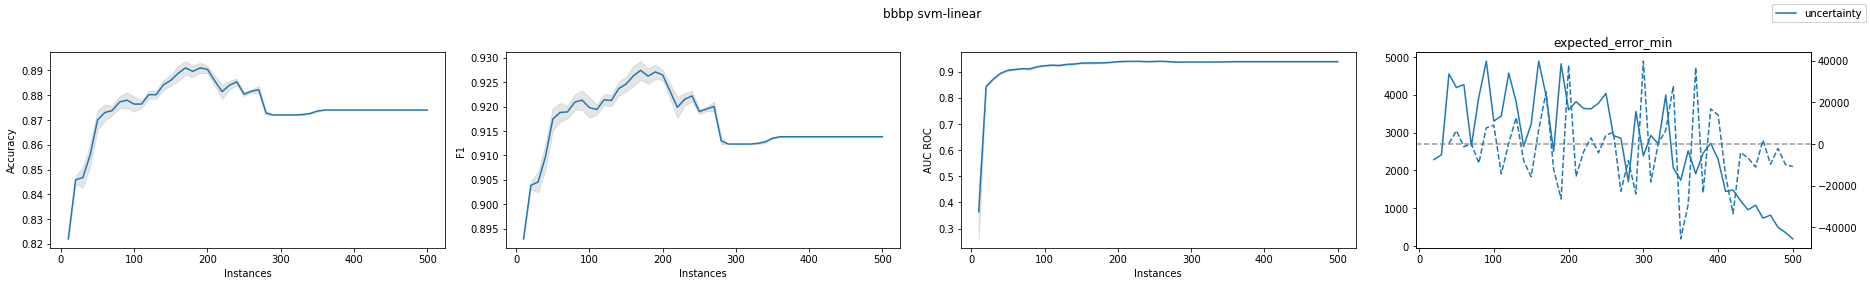

In [17]:
reload(libstop); reload(librun)
figaxes = librun.plot(results_plots, ret=True, sort=False, extra=1, figsize=(26,4))
for i, (fig, ax) in enumerate(figaxes):
    clfs = classifiers[i]
    metrics = results_plots[i][1][0].frame
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    accs = [first_acc(clfs_)[1] for clfs_ in clfs]
    accx = first_acc(clfs[0])[0]
    
    acc_median = np.median(accs, axis=0)
    acc_stderr = np.std(accs, axis=0)
    
    ax[-1].plot(metrics.x, metrics.expected_error_min)
    ax[-1].set_title("expected_error_min")
    
    ax2 = ax[-1].twinx()
    ax2.axhline(0, ls='--', color='grey', alpha=0.8)
    ax2.plot(metrics.x[1:], no_ahead_tvregdiff(metrics.expected_error_min[1:], 1, 1e-1, plotflag=False, diagflag=False), ls='--')
    
    
    #align_yaxis(ax[-1], ax2)
    
    #for ii, a in enumerate(ax):        
    #    for iii, (name, cond) in enumerate(stop_conditions.items()):
    #        stops = stop_results[results_plots[i][0].dataset_name][name]
    #        #a.axvline(np.median(stops), label=name if ii == 0 else None, color=colors[(iii+1)%len(colors)])
    #        #if name not in ["ZPS2", "SC_mes", "ZPS_ee"]:
    #        #    continue
    #        for iiii, stop in enumerate(stops[:1]):
    #            a.axvline(stop, label=name if ii == 0 and iiii ==0 else None, color=colors[(iii+1) % len(colors)])

    fig.legend()
    fig.tight_layout()

In [ ]:
rank_stop_conds(stop_results, "instances")
rank_stop_conds(stop_results, "accuracy_score")
rank_stop_conds(stop_results, "roc_auc_score")

In [ ]:
# i.e. gaining 1% of averaged (accuracy, ROC AUC) is worth training on x=100 extra instances
interact(lambda x: rank_stop_conds(stop_results, "holistic", title=f"(acc+roc_auc)/2*{x}*100 - runs", holistic_x=x), x=widgets.IntSlider(100, 10,200, continuous_update=False));